# SOUL Project Phase II
# Building Autoregressive LSTM using PyTorch (including validation)


## Part 1. LSTM으로 데이터 fitting하기

### Import libraries

In [139]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from economics_dataset import make_econ_dataframes

### Define Hyperparameters

In [140]:
learning_rate = 0.001
num_epochs = 500
timesteps_delayed = 52
input_dim = 110
hidden_dim = 100
num_layers = 2

### Get raw dataframes

In [141]:
dfs = make_econ_dataframes()
df_concat = pd.concat(dfs)
df_concat

1529
3490
4242
5597


,@frequency,provider_code,dataset_code,dataset_name,series_code,series_name,original_period,period,original_value,value,FREQ,INDICATOR,REF_AREA,frequency (label),indicator (label),country (label),Frequency,Reference Area,Indicator
0,quarterly,WB,GEM,Global Economic Monitor,Q-NYGDPMKTPSACD-CAN,"Quarterly – GDP,current US$,millions,seas. adj...",1987-Q1,1987-01-01,103187.381146,103187.381146,Q,NYGDPMKTPSACD,CA,Quarterly,"GDP,current US$,millions,seas. adj.,",Canada,NaN,NaN,NaN
1,quarterly,WB,GEM,Global Economic Monitor,Q-NYGDPMKTPSACD-CAN,"Quarterly – GDP,current US$,millions,seas. adj...",1987-Q2,1987-04-01,106405.184012,106405.184012,Q,NYGDPMKTPSACD,CA,Quarterly,"GDP,current US$,millions,seas. adj.,",Canada,NaN,NaN,NaN
2,quarterly,WB,GEM,Global Economic Monitor,Q-NYGDPMKTPSACD-CAN,"Quarterly – GDP,current US$,millions,seas. adj...",1987-Q3,1987-07-01,109964.200010,109964.200010,Q,NYGDPMKTPSACD,CA,Quarterly,"GDP,current US$,millions,seas. adj.,",Canada,NaN,NaN,NaN
3,quarterly,WB,GEM,Global Economic Monitor,Q-NYGDPMKTPSACD-CAN,"Quarterly – GDP,current US$,millions,seas. adj...",1987-Q4,1987-10-01,113587.295741,113587.295741,Q,NYGDPMKTPSACD,CA,Quarterly,"GDP,current US$,millions,seas. adj.,",Canada,NaN,NaN,NaN
4,quarterly,WB,GEM,Global Economic Monitor,Q-NYGDPMKTPSACD-CAN,"Quarterly – GDP,current US$,millions,seas. adj...",1988-Q1,1988-01-01,120463.636260,120463.636260,Q,NYGDPMKTPSACD,CA,Quarterly,"GDP,current US$,millions,seas. adj.,",Canada,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8108,monthly,IMF,CPI,Consumer Price Index (CPI),M.US.PCPI_PC_CP_A_PT,Monthly – United States – Consumer Price Index...,2021-03,2021-03-01,2.619763,2.619763,M,PCPI_PC_CP_A_PT,US,NaN,NaN,NaN,Monthly,United States,"Consumer Price Index, All items, Percentage ch..."
8109,monthly,IMF,CPI,Consumer Price Index (CPI),M.US.PCPI_PC_CP_A_PT,Monthly – United States – Consumer Price Index...,2021-04,2021-04-01,4.159695,4.159695,M,PCPI_PC_CP_A_PT,US,NaN,NaN,NaN,Monthly,United States,"Consumer Price Index, All items, Percentage ch..."
8110,monthly,IMF,CPI,Consumer Price Index (CPI),M.US.PCPI_PC_CP_A_PT,Monthly – United States – Consumer Price Index...,2021-05,2021-05-01,4.992707,4.992707,M,PCPI_PC_CP_A_PT,US,NaN,NaN,NaN,Monthly,United States,"Consumer Price Index, All items, Percentage ch..."
8111,monthly,IMF,CPI,Consumer Price Index (CPI),M.US.PCPI_PC_CP_A_PT,Monthly – United States – Consumer Price Index...,2021-06,2021-06-01,5.391451,5.391451,M,PCPI_PC_CP_A_PT,US,NaN,NaN,NaN,Monthly,United States,"Consumer Price Index, All items, Percentage ch..."


### Organize and interpolate dataframe

In [142]:
df_organized = df_concat.loc[:, ["period", "value", "INDICATOR", 'REF_AREA']].pivot(index="period", columns=['INDICATOR', 'REF_AREA'], values='value')
df_organized

INDICATOR   NYGDPMKTPSACD                                             \
REF_AREA               CA            CN            DE             FR   
period                                                                 
1976-01-01            NaN           NaN           NaN            NaN   
1976-02-01            NaN           NaN           NaN            NaN   
1976-03-01            NaN           NaN           NaN            NaN   
1976-04-01            NaN           NaN           NaN            NaN   
1976-05-01            NaN           NaN           NaN            NaN   
...                   ...           ...           ...            ...   
2021-03-01            NaN           NaN           NaN            NaN   
2021-04-01  501585.343855  4.434057e+06  1.076314e+06  743368.299605   
2021-05-01            NaN           NaN           NaN            NaN   
2021-06-01            NaN           NaN           NaN            NaN   
2021-07-01  502220.492804  4.448017e+06  1.079964e+06  748787.816314   

INDICATOR                                                              \
REF_AREA               GB             IN             IT            JP   
period                                                                  
1976-01-01            NaN            NaN            NaN           NaN   
1976-02-01            NaN            NaN            NaN           NaN   
1976-03-01            NaN            NaN            NaN           NaN   
1976-04-01            NaN            NaN            NaN           NaN   
1976-05-01            NaN            NaN            NaN           NaN   
...                   ...            ...            ...           ...   
2021-03-01            NaN            NaN            NaN           NaN   
2021-04-01  794627.047771  693649.301188  542486.206160  1.260837e+06   
2021-05-01            NaN            NaN            NaN           NaN   
2021-06-01            NaN            NaN            NaN           NaN   
2021-07-01  801698.367415  781205.995281  546881.389051  1.245563e+06   

INDICATOR                                 ... PCPI_PC_CP_A_PT            \
REF_AREA               KR             RU  ...              CN        DE   
period                                    ...                             
1976-01-01            NaN            NaN  ...             NaN  5.192646   
1976-02-01            NaN            NaN  ...             NaN  5.333325   
1976-03-01            NaN            NaN  ...             NaN  5.140950   
1976-04-01            NaN            NaN  ...             NaN  4.769746   
1976-05-01            NaN            NaN  ...             NaN  4.418988   
...                   ...            ...  ...             ...       ...   
2021-03-01            NaN            NaN  ...        0.321924  1.794616   
2021-04-01  461454.876269  444939.086405  ...        0.922645  1.992032   
2021-05-01            NaN            NaN  ...        1.644355  2.191235   
2021-06-01            NaN            NaN  ...        1.240203  2.388060   
2021-07-01  451956.233991  472448.700685  ...        1.912559  3.711133   

INDICATOR                                                                   \
REF_AREA          FR         GB         IN         IT        JP         KR   
period                                                                       
1976-01-01  9.595639  23.352821  -8.565744  10.968167  8.620690  23.027102   
1976-02-01  9.523785  22.887616 -10.726196  11.775379  9.386973  22.175460   
1976-03-01  9.581651  21.158504 -10.923806  13.872148  8.728653  21.982903   
1976-04-01  9.565211  18.900051 -10.522759  15.357186  9.328358  19.517689   
1976-05-01  9.495347  15.390326 -11.258303  16.706054  9.276438  16.093147   
...              ...        ...        ...        ...       ...        ...   
2021-03-01  1.109093   1.012891   5.518170   0.777454 -0.398804   1.901141   
2021-04-01  1.243305   1.657459   4.227213   1.067961 -1.097804   2.492462   
2021-05-01  1.422978   2.209945   6.295560   1.264591 -0.69

In [143]:
df_interpolated = df_organized.interpolate(method='time', limit_direction='both')
df_resampled = df_interpolated.resample(rule="W")
df_interpolated = df_resampled.interpolate(method='time', limit_direction='both')
# df_interpolated = df_interpolated.dropna(axis=1, how='any')
print(df_interpolated)
print(df_interpolated.isna().any().any())

INDICATOR   NYGDPMKTPSACD                                             \
REF_AREA               CA            CN            DE             FR   
period                                                                 
1976-01-04  103187.381146  1.109022e+05  3.056626e+05  237856.863734   
1976-01-11  103187.381146  1.109022e+05  3.056626e+05  237856.863734   
1976-01-18  103187.381146  1.109022e+05  3.056626e+05  237856.863734   
1976-01-25  103187.381146  1.109022e+05  3.056626e+05  237856.863734   
1976-02-01  103187.381146  1.109022e+05  3.056626e+05  237856.863734   
...                   ...           ...           ...            ...   
2021-06-06  456219.398101  4.136576e+06  1.042646e+06  723567.339483   
2021-06-13  456219.398101  4.136576e+06  1.042646e+06  723567.339483   
2021-06-20  456219.398101  4.136576e+06  1.042646e+06  723567.339483   
2021-06-27  456219.398101  4.136576e+06  1.042646e+06  723567.339483   
2021-07-04  456219.398101  4.136576e+06  1.042646e+06  723567.33

In [144]:
df_ema = df_interpolated.ewm(span=52).mean()

### Obtain difference values for each column

In [145]:
# Assuming 'df' is your DataFrame
df = df_ema

# Function to prepend NaN and calculate diff
def prepend_nan_and_diff(series):
    diff_series = np.diff(series)
    # Prepend NaN to the differences array
    return np.insert(diff_series, 0, np.nan)

# Iterate over the top-level columns and calculate diffs
new_columns = []
for col in df.columns.levels[0]:
    for sub_col in df[col].columns:
        # Calculate diff for each subcolumn under the top-level column
        diff_values = prepend_nan_and_diff(df[col][sub_col])
        # Add the original and diff columns to the new_columns list
        new_columns.append(((col, sub_col, 'value'), df[col][sub_col]))
        new_columns.append(((col, sub_col, 'increment'), diff_values))

# Create a new DataFrame with multi-level columns from the new_columns list
df_diffed = pd.DataFrame(dict(new_columns))
df_diffed.columns = pd.MultiIndex.from_tuples(df_diffed.columns)


# Sort the columns to maintain a logical order if needed
# new_df = new_df.sort_index(axis=1)[1:]
df_diffed = df_diffed[1:] # remove NaN
print(df_diffed.head())


           BACK_BP6_USD                                                 \
                     CA                      CN                     DE   
                  value increment         value increment        value   
period                                                                   
1976-01-11 -2351.709601  0.000000  24834.082133       0.0  1395.909133   
1976-01-18 -2351.709601  0.000000  24834.082133       0.0  1395.909133   
1976-01-25 -2351.709601  0.000000  24834.082133       0.0  1395.909133   
1976-02-01 -2351.709601  0.000000  24834.082133       0.0  1395.909133   
1976-02-08 -2343.603590  8.106011  24834.082133       0.0  1388.215519   

                                                                  ...  \
                              FR                    GB            ...   
           increment       value increment       value increment  ...   
period                                                            ...   
1976-01-11  0.000000 -441.061116  0.00000

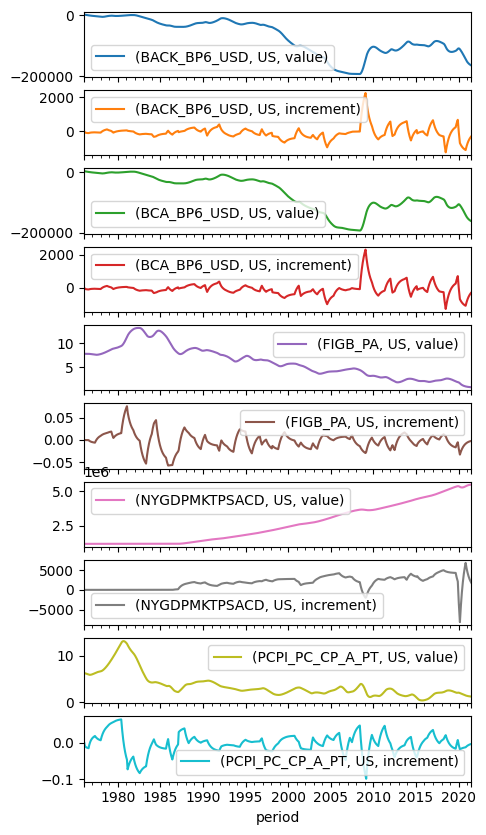

In [146]:
_ = df_diffed.loc[:, (slice(None), 'US')].plot(subplots=True, figsize=(5, 10))

In [147]:
df_diffed.describe()

BACK_BP6_USD                                                         \
                 CA                          CN                         DE   
              value    increment          value    increment         value   
count   2374.000000  2374.000000    2374.000000  2374.000000   2374.000000   
mean   -3505.885607     0.145721   36256.165609    29.541805  22824.878532   
std     5655.345464    54.934997   20140.677126   370.770591  30445.198740   
min   -15979.640940  -286.792574   10866.469451 -1560.237739  -9127.695762   
25%    -5860.067785   -21.368660   24834.082133     0.000000  -2930.729169   
50%    -2472.794223     2.071045   24834.082133     0.000000   6713.684476   
75%     -129.759581    30.034263   43305.140643     0.000000  53060.731554   
max     5647.652665   150.883642  100880.711796  1622.007550  84031.056457   

                                                                          ...  \
                              FR                         GB               ...   
         increment         value    increment         value    increment  ...   
count  2374.000000   2374.000000  2374.000000   2374.000000  2374.000000  ...   
mean     34.808402    -39.916710     1.239443 -10713.525968   -10.957946  ...   
std     150.326401   4761.954600   103.275282  11674.399446   119.692868  ...   
min    -706.999127 -14502.986867  -659.967383 -40068.627199  -468.266032  ...   
25%     -38.111331  -2380.761708   -30.427997 -18472.574543   -69.245856  ...   
50%      23.885608   -511.318170     5.783509  -7660.729609   -10.203106  ...   
75%      88.008832   2972.267548    41.326000   -472.265957    30.594936  ...   
max     620.590923  12451.004209   474.934984   3738.958093   476.891463  ...   

      PCPI_PC_CP_A_PT                                                      \
                   IT                        JP                        KR   
                value    increment        value    increment        value   
count     2374.000000  2374.000000  2374.000000  2374.000000  2374.000000   
mean         5.504215    -0.005015     1.538078    -0.004280     5.736814   
std          5.432486     0.031578     2.395157     0.024112     5.616738   
min         -0.129956    -0.085143    -1.319627    -0.102903     0.136144   
25%          1.823235    -0.016979    -0.018004    -0.018748     2.318693   
50%          2.833561    -0.005463     0.665639    -0.001267     3.765128   
75%          6.185089     0.006866     2.366790     0.007970     6.584288   
max         18.988755     0.135626     9.434405     0.074572    24.838799   

                                                                        
                             RU                        US               
         increment        value    increment        value    increment  
count  2374.000000  2374.000000  2374.000000  2374.000000  2374.000000  
mean     -0.009081   369.512374    -0.356467     3.601645    -0.002118  
std       0.058364   403.112529     1.466734     2.616901     0.026059  
min      -0.267705     2.836802    -9.035565     0.423776    -0.098342  
25%      -0.022358    10.512490    -0.070472     2.075322    -0.014433  
50%      -0.001939    55.831463     0.000000     2.778769    -0.000216  
75%       0.015853   850.456898     0.000000     4.166571     0.011699  
max       0.154548   905.920510     2.114331    13.150504     0.063597  

[8 rows x 108 columns]

### Add time of year signal

In [148]:
day = 24*60*60
year = (365.242374)*day

df_trig = df_diffed.copy()
timestamp_s = df_diffed.index.map(pd.Timestamp.timestamp)
df_trig['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_trig['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

### Split train/validation/test dataset

In [149]:
df = df_trig.copy()
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

### Apply StandardScaler

In [150]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)
scaled = scaler.transform(df)
print(scaled[0:5,:])

[[-4.61050630e-01 -1.13544632e-01 -2.36224434e-01 -2.55449403e-01
  -2.45668912e-01 -2.46369192e-01 -6.58063069e-01  2.93605426e-03
   6.76560538e-01  2.63852470e-01  8.78021669e-01  7.37828086e-02
  -3.01771211e-01  1.54925670e-02 -4.92893692e-01 -2.81190927e-01
  -3.72368048e-01 -4.29255490e-02 -4.19938378e-01 -1.12596038e-01
   9.30589312e-01  5.74581970e-01 -5.02160626e-01 -1.16657872e-01
  -2.36035168e-01 -2.55927949e-01 -2.76964180e-01 -2.46274090e-01
  -6.48650372e-01  1.13554680e-02  6.85327983e-01  2.59708624e-01
   8.78021669e-01  7.37828086e-02 -2.43726320e-01  2.12156428e-02
  -4.93177838e-01 -2.52521336e-01 -3.72667348e-01 -4.29829889e-02
  -4.90611352e-01 -1.37261278e-01  9.29789762e-01  5.70270966e-01
   2.55206557e-01  1.61876105e-01  8.97558949e-01  1.41550817e-01
   2.45810014e-01  1.37254876e-01  1.40983495e+00  2.64180717e-01
  -1.61276279e+00 -2.06794695e-01  6.87012163e-01  1.92376653e-01
   5.28312190e-01  8.70675278e-02  1.26708066e+00  2.12866603e-01
   2.60619

### Plot violin plot

/var/folders/cr/4ychhhxn41b3ts91p71bs_040000gn/T/ipykernel_90598/1548470197.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax_us.set_xticklabels(ax_us.get_xticklabels(), rotation=90)
/var/folders/cr/4ychhhxn41b3ts91p71bs_040000gn/T/ipykernel_90598/1548470197.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax_kr.set_xticklabels(ax_kr.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


            BACK_BP6_USD_CA_value  BACK_BP6_USD_CA_increment  \
period                                                         
1976-01-11              -0.461051                  -0.113545   
1976-01-18              -0.461051                  -0.113545   
1976-01-25              -0.461051                  -0.113545   
1976-02-01              -0.461051                  -0.113545   
1976-02-08              -0.458544                   0.127985   

            BACK_BP6_USD_CN_value  BACK_BP6_USD_CN_increment  \
period                                                         
1976-01-11              -0.236224                  -0.255449   
1976-01-18              -0.236224                  -0.255449   
1976-01-25              -0.236224                  -0.255449   
1976-02-01              -0.236224                  -0.255449   
1976-02-08              -0.236224                  -0.255449   

            BACK_BP6_USD_DE_value  BACK_BP6_USD_DE_increment  \
period                                

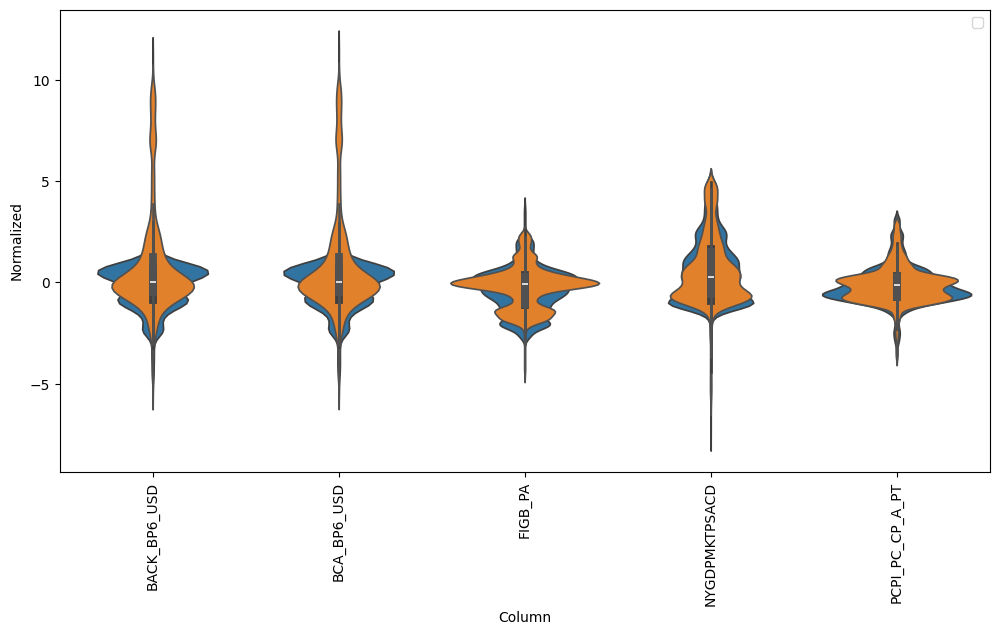

In [151]:
import seaborn as sns

# Flatten the multi-level column headers
flatted_columns = ['_'.join(col).strip() for col in df.columns.values]
df_scaled = pd.DataFrame(scaled, index=df.index, columns=flatted_columns)

# Now, melt the DataFrame
df_scaled_us = pd.DataFrame(scaled, index=df.index, columns=df.columns).loc[:, (slice(None), 'US', slice(None))]
df_scaled_kr = pd.DataFrame(scaled, index=df.index, columns=df.columns).loc[:, (slice(None), 'KR', slice(None))]
df_melted_us = df_scaled_us.melt(var_name='Column', value_name='Normalized')
df_melted_kr = df_scaled_kr.melt(var_name='Column', value_name='Normalized')

# Plotting
plt.figure(figsize=(12, 6))
ax_us = sns.violinplot(x='Column', y='Normalized', data=df_melted_us)
ax_kr = sns.violinplot(x='Column', y='Normalized', data=df_melted_kr)
_ = ax_us.set_xticklabels(ax_us.get_xticklabels(), rotation=90)
_ = ax_kr.set_xticklabels(ax_kr.get_xticklabels(), rotation=90)
ax_us.legend()
ax_kr.legend()

print(df_scaled.head())


### Outputs should be shifed inputs / reshaping to fit LSTM input

In [152]:
x_train = train_scaled[:len(train_scaled)-timesteps_delayed]
y_train = train_scaled[timesteps_delayed:len(train_scaled)]
x_val = val_scaled[:len(val_scaled)-timesteps_delayed]
y_val = val_scaled[timesteps_delayed:len(val_scaled)]
x_test = test_scaled[:len(test_scaled)-timesteps_delayed]
y_test = test_scaled[timesteps_delayed:len(test_scaled)]

device = 'cpu'
x_train = torch.Tensor(x_train).to(device)
y_train = torch.Tensor(y_train).to(device)
x_val = torch.Tensor(x_val).to(device)
y_val = torch.Tensor(y_val).to(device)
x_test = torch.Tensor(x_test).to(device)
y_test = torch.Tensor(y_test).to(device)

x_train = x_train.view(len(x_train), 1, -1)
y_train = y_train.view(len(y_train), 1, -1)
x_val = x_val.view(len(x_val), 1, -1)
y_val = y_val.view(len(y_val), 1, -1)
x_test = x_test.view(len(x_test), 1, -1)
y_test = y_test.view(len(y_test), 1, -1)

print(f"x_train.size(): {x_train.size()}")
print(f"y_train.size(): {y_train.size()}")
print(f"x_val.size(): {x_val.size()}")
print(f"y_val.size(): {y_val.size()}")
print(f"x_test.size(): {x_test.size()}")
print(f"x_test.size(): {x_test.size()}")

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=64)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=64)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=64)


x_train.size(): torch.Size([1609, 1, 110])
y_train.size(): torch.Size([1609, 1, 110])
x_val.size(): torch.Size([423, 1, 110])
y_val.size(): torch.Size([423, 1, 110])
x_test.size(): torch.Size([186, 1, 110])
x_test.size(): torch.Size([186, 1, 110])


In [153]:
torch.manual_seed(1)
lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers).to(device)
linear = nn.Linear(hidden_dim, input_dim).to(device)
optimizer = optim.Adam([*lstm.parameters(), *linear.parameters()], lr=learning_rate)
loss_function = nn.MSELoss(reduction='sum').to(device)

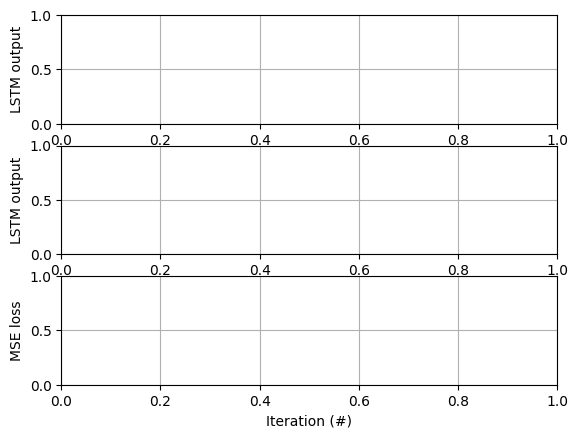

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.set_xlabel("Time (months)")
ax1.set_ylabel("LSTM output")
ax1.grid(True)
ax2.set_xlabel("Time (months)")
ax2.set_ylabel("LSTM output")
ax2.grid(True)
ax3.set_xlabel("Iteration (#)")
ax3.set_ylabel("MSE loss")
ax3.grid(True)

In [155]:
first_feature_idx = 4
second_feature_idx = 5

val_times = range(len(x_train), len(x_train)+len(x_val))
ax1.plot(x_train.detach().numpy()[:, 0, first_feature_idx], label="train data")
ax1.plot(val_times, x_val.detach().numpy()[:, 0, first_feature_idx], label="val data")
ax2.plot(x_train.detach().numpy()[:, 0, second_feature_idx], label="train data")
ax2.plot(val_times, x_val.detach().numpy()[:, 0, second_feature_idx], label="val data")

In [156]:
def make_hidden_init():
    return (torch.randn(num_layers, 1, hidden_dim).to(device), torch.randn(num_layers, 1, hidden_dim).to(device))

train_losses = []
val_losses = []
for epoch in range(1, num_epochs+1):
    lstm.train()
    linear.train()
    total_train_loss = 0
    optimizer.zero_grad()     # optimizer에 누적된 gradient 0으로 초기화
    hidden_init = make_hidden_init()
    out_train, hidden = lstm(x_train, hidden_init)  # lstm 통과
    out_train = linear(out_train)                    # linear layer 통과
    loss = loss_function(y_train, out_train)   # loss 값 계산
    loss.backward()                              # 역전파 수행
    optimizer.step()                             # 가중치 업데이트
    total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(x_train)
    train_losses.append(avg_train_loss)

    hidden_save = hidden

    lstm.eval()
    linear.eval()
    total_val_loss = 0
    with torch.no_grad():
        out_val, hidden_val = lstm(x_val, hidden_save)  # lstm 통과
        out_val = linear(out_val)
        loss = loss_function(y_val, out_val)
        total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(x_val)  # Compute average loss
    val_losses.append(avg_val_loss)

    if epoch in [1, num_epochs]: #num_epochs/12, num_epochs/2, num_epochs]:   # 중간 점검
        x, xs = x_train[-1].unsqueeze(0), []
        hidden = hidden_save
        for i in range(5*52):
            x, hidden = lstm(x, hidden)
            x = linear(x)
            xs.append(x.detach().numpy())
        autoreg_times = range(len(x_train)+timesteps_delayed, len(x_train)+timesteps_delayed+5*52)
        train_output_times = range(timesteps_delayed, len(x_train)+timesteps_delayed)
        first_feature = np.array([x[0, 0, first_feature_idx] for x in xs])
        second_feature = (np.sqrt(scaler.var_[first_feature_idx]) * np.diff(np.insert(first_feature, 0, np.nan)) - scaler.mean_[second_feature_idx]) / np.sqrt(scaler.var_[second_feature_idx])
        ax1.plot(train_output_times, out_train.detach().numpy()[:, 0, first_feature_idx], label=f"training {epoch}")
        ax1.plot(autoreg_times, first_feature, label=f"autoregressive prediction {epoch}")
        ax2.plot(train_output_times, out_train.detach().numpy()[:, 0, second_feature_idx], label=f"training {epoch}")
        ax2.plot(autoreg_times, second_feature, label=f"autoregressive prediction {epoch}")
        print(f"Epoch {epoch}/{num_epochs} - Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

Epoch 1/500 - Training Loss: 110.2876, Validation Loss: 1092.4244
Epoch 500/500 - Training Loss: 0.3000, Validation Loss: 897.8808


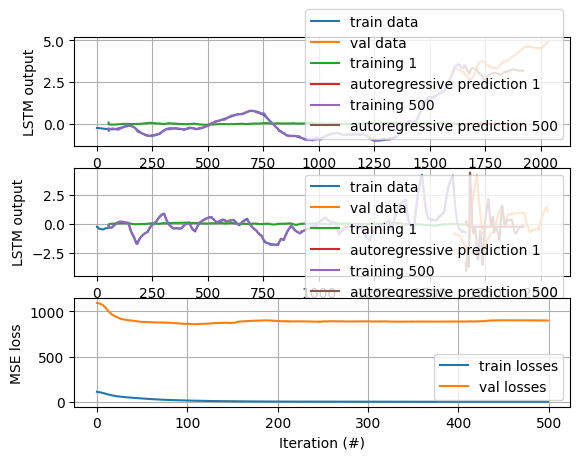

In [157]:
ax3.plot(train_losses, label="train losses")
ax3.plot(val_losses, label="val losses")
ax1.legend()
ax2.legend()
ax3.legend()
fig

In [158]:
fig.set_size_inches(16, 16)
fig.savefig(f"SOUL_PhaseI_Part2_[{learning_rate}][{num_epochs}][{timesteps_delayed}][{input_dim}][{hidden_dim}].jpg", dpi=200)

In [ ]:
torch.save(lstm.state_dict(), "lstm_state_dict.pth")
torch.save(linear.state_dict(), "linear_state_dict.pth")
torch.save(x_save, "x_save.pth")
torch.save(hidden_save, "hidden_save.pth")
df_scaled.to_csv('df_scaled.csv')